In [13]:
#-----------------import statements--------------------------------------------------------------------
import numpy as np
import pylab

import random
import math
from collections import defaultdict 
import sys
import csv
from time import time
import pandas as pd
from sklearn.datasets import make_blobs,make_circles,make_moons #for DBSCAN

import networkx as nx #for display uniquely
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#                    Part I: GRAPH CLASS AND COMPUTING SCC'S

###                                                 GRAPH CLASS

In [14]:
class Graph:#graph represented byadjacency list 

    def __init__(self,vertices): 
        self.V= vertices #No. of vertices
        self.E=0;
        self.graph = defaultdict(list) # default dictionary to store graph
        self.c=0#cluster counter  
        self.label=[0 for i in range(vertices)]
        self.Time = 0#for tarjan
        self.networkx_G=nx.DiGraph()#for display uniquely
        

    def addEdge(self,i,j): 
        self.graph[i].append(j)
        self.E+=1;
#---------------------------SCC Algo #1: Korasaju----------------------------------------------------------------------
    def aux_dfs_korasaju(self,v,visited,c): 
        visited[v]= True #check off current vertex as visited and define its label, then move on to unvisited neighbors
        self.label[v]=c
      
        for i in self.graph[v]: 
            if visited[i]==False: 
                self.aux_dfs_korasaju(i,visited,c) 

    def DFS_korasaju(self,v,visited, stack): #korasaju depth first search
        #check off current vertex as visited
        visited[v]= True
        #Recur for all the vertices adjacent to this vertex 
        for i in self.graph[v]: 
            if visited[i]==False: 
                self.DFS_korasaju(i, visited, stack) 
        stack = stack.append(v) 


    # calculate transpose of g, needed for korasaju
    def get_transpose(self): 
        g = Graph(self.V) 

        # Recur for all the vertices adjacent to this vertex 
        for i in self.graph: 
            for j in self.graph[i]: 
                g.addEdge(j,i) 
        return g 

    def findSCCs_korasaju(self): #korasaju main function
        self.c=0;
        self.label=[0 for i in range(self.V)]
      
        stack = [] 
        
        # First round of DFS
        visited =[False]*(self.V) #initialize nodes to unvisited 
        # Go through stack in order of finishing time
        for i in range(self.V): 
            if visited[i]==False: 
                self.DFS_korasaju(i, visited, stack) 
        
        # Second round of DFS (reverse direction)
        g_reversed = self.get_transpose() 
        visited =[False]*(self.V) # reinitialize nodes to unvisited 

        # iterate through nodes according to stack order
        while stack: 
            i = stack.pop() 
            if visited[i]==False:
                g_reversed.aux_dfs_korasaju(i, visited,self.c)
                self.c+=1
            
        self.label=g_reversed.label

#------------------------------SCC Algo #2: Tarjan---------------------------------------------------------------------
    
    def findSCCs_tarjan(self): 
        #INITIALIZATION
        self.c=0
        self.label=[0 for i in range(self.V)]
   
        discovery_order = [-1] * (self.V) #mark nodes as unvisited 
        low = [-1] * (self.V) # low[u]=node visited earliest from in DFS subtree roooted at node u
        is_in_stack = [False] * (self.V) # boolean array for verifying stack membership
        stack =[] #keep track of connected ancestors 
          
        # Find "bridge points" (heads of SCC's) in DFS sub-tree rooted at node i 
        for i in range(self.V): 
            if discovery_order[i] == -1: 
                self.DFS_tarjan(i, low, discovery_order, is_in_stack, stack)
                
    def DFS_tarjan(self,u, low, discovery_order, is_in_stack, stack): #auxillary function for performing DFS
  
        # Initialize discovery times and low value 
        discovery_order[u] = self.Time 
        low[u] = self.Time 
        self.Time += 1
        is_in_stack[u] = True
        stack.append(u) 

        for v in self.graph[u]: #iterate through neighbors of v
              
            if discovery_order[v] == -1 : #if v unvisited
              
                self.DFS_tarjan(v, low, discovery_order, is_in_stack, stack) 
                # Determine if subtree rooted in v is connected to an ancestors of u, update low[u] accordingly
                low[u] = min(low[u], low[v]) 
                          
            elif is_in_stack[v] == True:  
                #Update low[u] if 'v' remains in stack
                low[u] = min(low[u], discovery_order[v]) 
  
        # head node reached: pop stack and increase SCC count
        extracted = -1 #To store nodes popped from stack
        if low[u] == discovery_order[u]: 
            while extracted != u: 
                extracted = stack.pop() 
                self.label[extracted]=self.c
                is_in_stack[extracted] = False
            self.c+=1

            
    def freq_plot(self,*args): #plots size distribution of SCC/clusters given labels and number of clusters c 
        size=[0 for j in range(self.c)]
        for j in range(len(self.label)): size[self.label[j]]+=1
        mp = dict() 

        # Traverse through array elements  
        # and count frequencies 
        for i in range(self.c): 
            if size[i] in mp.keys(): 
                mp[size[i]] += 1
            else: 
                mp[size[i]] = 1

        # Traverse through map and print  
        # frequencies 
        print ("\nclustersize | frequency")
        for x in mp: print (x," |",mp[x])
            
        if len(args)==0:
            plt.figure()
            plt.title("Clustersize distribution")
            plt.xlabel("cluster size")
            plt.ylabel("frequency")
            plt.bar ([x for x in mp], [mp[x] for x in mp])
            plt.show()

#--------------------------------------DISPLAY---------------------------------------------------------

    def display(self,*args):
        #args=(pos,Node_size,xlabel,ylabel,title,edge_width,_arrows)
        #we use networkx module to display graphs, unfortunately this requires reconstructing the graph...

        #make networkx graph
        self.networkx_G.add_nodes_from(range(self.V))
        for i in range(self.V):
            for j in self.graph[i]:
                self.networkx_G.add_edge(i,j)

        #define display properties if they were inputted, default otherwise
        if len (args)>=2: pos=args[1]
        else: 
            pos = nx.spring_layout(self.networkx_G)
        if len(args)>=3: Node_size=args[2]
        else: Node_size=300 # default  
        if len(args)>=7: edge_width=args[6]
        else: edge_width=1 #default
        if len(args)>=8: _arrows=args[7]
        else:_arrows=True


        plt.figure()
 

        if len(args)>=4: plt.xlabel(args[3])
        if len(args)>=5: plt.ylabel(args[4])
        if len(args)>=6: plt.title(args[5])

        #draw graph
        nx.draw_networkx_nodes(self.networkx_G, pos,node_size=Node_size, cmap=plt.get_cmap('rainbow'), 
                       node_color = self.label)
        
        if (len(args)==0 or args[0]==True): nx.draw_networkx_labels(self.networkx_G, pos)
        nx.draw_networkx_edges(self.networkx_G,pos,arrows=_arrows,width=edge_width)
        
    
        plt.show()    

print("Graph class compiled!")



Graph class compiled!


In [15]:
#---------------------------------------Erdos Renyi-------------------------------------------
def erdos_renyi(n,p):#generates erdos-renyi digraph on n vertices,edge probability =p
    g=Graph(n)
    for i in range(n):
        for j in range(n):
            if (i==j): continue
            r=random.uniform(0,1)
            if (r<=p):
                    g.addEdge(i,j)
    return g

###                                                 COMPUTING SCC'S ON SMALL EXAMPLES

G=(V,E), V=5, E=5


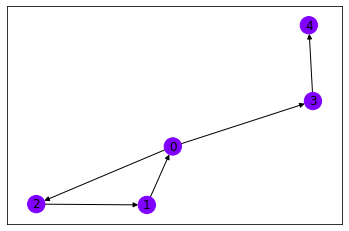

Computing SCC's...


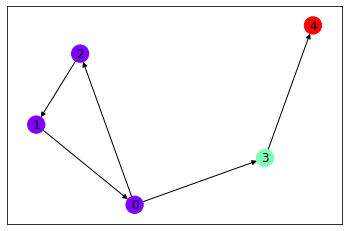


# SCC (korasaju): 3
SCC labels (korasaju): [0, 0, 0, 1, 2]

# SCC (tarjan): 3
SCC labels (korasaju): [2, 2, 2, 1, 0]

-----------------------------------------------------------
G=(V,E), V=11, E=17


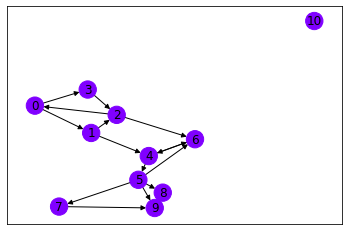

Computing SCC's...


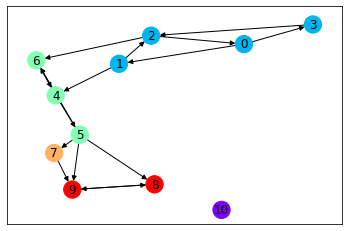


# SCC (korasaju): 5
SCC labels (korasaju): [1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 0]

# SCC (tarjan): 5
SCC labels (tarjan): [3, 3, 3, 3, 2, 2, 2, 1, 0, 0, 4]

clustersize | frequency
2  | 1
1  | 2
3  | 1
4  | 1


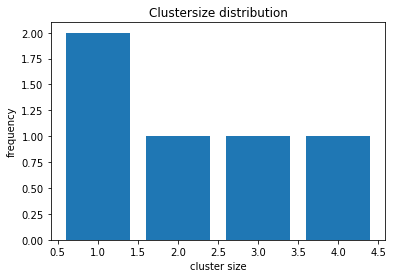

-----------------------------------------------------------

G=ER(n,p), n=20, p= 0.1
edges: 49


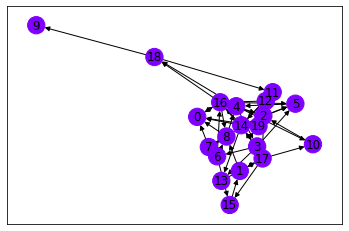

Computing SCC's...


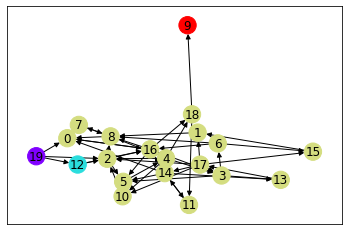


# SCC (korasaju): 4
runtime =0 ms

# SCC (tarjan): 4
runtime =0 ms


In [16]:
#-----------------------------Testing SCC algorithms and visualization on small examples-------------------------------------------------------
# Create a graph given in the above diagram 
g1 = Graph(5) 
g1.addEdge(1, 0) 
g1.addEdge(0, 2) 
g1.addEdge(2, 1) 
g1.addEdge(0, 3) 
g1.addEdge(3, 4) 


print ("G=(V,E), V=" + str(g1.V)+ ", E=" +str(g1.E))
g1.display()

print("Computing SCC's...")

g1.findSCCs_korasaju() 
g1.display()

print ("\n# SCC (korasaju): "+str(g1.c))
print ("SCC labels (korasaju): "+str(g1.label))

g1.findSCCs_tarjan() 

print ("\n# SCC (tarjan): "+str(g1.c))
print ("SCC labels (korasaju): "+str(g1.label))

#------------------------------------------------------------------------------------------
g2=Graph (11) 

g2.addEdge(0,1);g2.addEdge(0,3); 
g2.addEdge(1,2);g2.addEdge(1,4); 
g2.addEdge(2,0);g2.addEdge(2,6); 
g2.addEdge(3,2); 
g2.addEdge(4,5);g2.addEdge(4,6); 
g2.addEdge(5,6);g2.addEdge(5,7);g2.addEdge(5,8);g2.addEdge(5,9); 
g2.addEdge(6,4); 
g2.addEdge(7,9); 
g2.addEdge(8,9); 
g2.addEdge(9,8); 

print ("\n-----------------------------------------------------------")
print ("G=(V,E), V=" + str(g2.V)+ ", E=" +str(g2.E))

g2.display()


print("Computing SCC's...")

g2.findSCCs_korasaju() 
g2.display()

print ("\n# SCC (korasaju): "+str(g2.c))
print ("SCC labels (korasaju): "+str(g2.label))

g2.findSCCs_tarjan() 

print ("\n# SCC (tarjan): "+str(g2.c))
print ("SCC labels (tarjan): "+str(g2.label))

g2.freq_plot()

#-----------------------------------------Erdos Renyi test--------------------------------------------------------
n=20
p=0.1
g3=erdos_renyi(n,p)

print ("-----------------------------------------------------------\n")
print ("G=ER(n,p), n="+ str(n)+", p= " +str(p))
print ("edges: "+ str(g3.E))

g3.display()

print("Computing SCC's...")

start=time()
g3.findSCCs_korasaju() 
stop=time()
g3.display()
print ("\n# SCC (korasaju): "+str(g3.c))
print('runtime ='+str(round((stop-start)*1000.0))+" ms")


start=time()
g3.findSCCs_tarjan() 
stop=time()
print ("\n# SCC (tarjan): "+str(g3.c))
print('runtime ='+str(round((stop-start)*1000.0))+" ms")

###                                                            FINDING SCC'S ON REAL DATA

In [17]:
#-------------------------------------------FINDING SCC's on real data-------------------------------------------------------
#********!!!!!!!!!!!!!!NOTE: ANY WHITESPACE AFTER LAST LINE OF TEXTFILE MUST BE REMOVED!!!!!!!!!!!!!!!!!!******************

sys.setrecursionlimit(10**6) #Necessary to not exceed max recursion depth on big datasets!

file_name='Wiki-Vote'
file_type='.txt'
skip=4#number of lines to skip when reading text file
nodes= 7115

#----------------------------------------LOAD DATA AND BUILD GRAPH---------------------------------------------------
#Sometimes nodes indices are not consective starting at 0 so we should use a dictionary to map them to proper format
node_ind = dict() 
ind=0

g2 = Graph(nodes) 

#read file 
f=open(file_name+file_type,'r') 
lines = f.readlines()[skip:]

for line in lines:
    p = line.split()
    
    if not(int(p[0]) in node_ind.keys()): 
        node_ind[int(p[0])]=ind
        ind+=1
    if not(int(p[1]) in node_ind.keys()): 
        node_ind[int(p[1])]=ind
        ind+=1
        
    ind1=node_ind[int(p[0])]
    ind2=node_ind[int(p[1])]
    g2.addEdge(ind1,ind2)
    
f.close() 
print ("-----------------------------------------------------------")
print (file_name+": G=(V,E), V="+ str(nodes)+", E= " +str(g2.E))
#-----------------------------------------FIND SCC's-----------------------------------------

start=time()
g2.findSCCs_korasaju() 
stop=time()
print ("\n# SCC (korasaju): "+str(g2.c))
print('runtime ='+str(round((stop-start)*1000.0))+" ms")


start=time()
g2.findSCCs_tarjan() 
stop=time()
print ("\n# SCC (tarjan): "+str(g2.c))
print('runtime ='+str(round((stop-start)*1000.0))+" ms")

g2.freq_plot(False)

-----------------------------------------------------------
Wiki-Vote: G=(V,E), V=7115, E= 103689

# SCC (korasaju): 5816
runtime =94 ms

# SCC (tarjan): 5816
runtime =16 ms

clustersize | frequency
1  | 5815
1300  | 1


#                    Part II: ERDOS RENYI STATISTICS

Text(0.5, 1.0, 'Largest SCC size in ER(n,p), n=20')

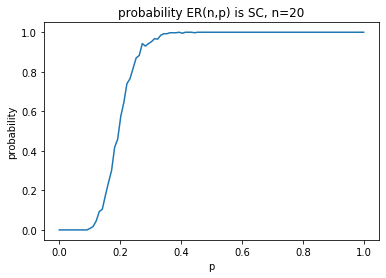

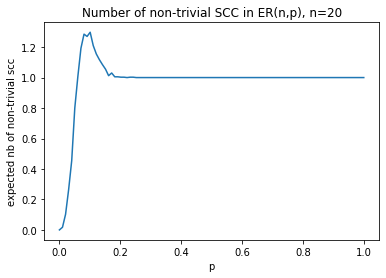

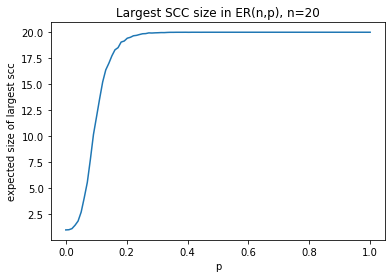

In [18]:
#-----------------ERDOS RENYI STATISTICS-------------------------

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NOTE: OUTPUTTING GRAPHS TAKES ABOUT 20 s !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

#non trivial scc = scc with >1 nodes
#is p is small, 0 non trivial scc
#if p too large, whole graph is one scc
#How does p affect the number and size of scc's?

n=20
nb_p=100
nb_runs=400 #number of runs to collect statistics on ER(n,p) graphs

print("Collecting statistics on ER(n,p) for n="+str(n)+" ("+str(nb_p)+ " values of p in [0,1])... \n")

prob_unique_scc=[]
ex_nb_non_trivial_scc=[]
ex_size_largest_scc=[]
probs=np.linspace(0,1,nb_p)

for p in probs:
    count_unique_scc=0
    sum_max_scc_sizes=0
    sum_nb_non_trivial_clusters=0
    
    for run in range(nb_runs):
        g=erdos_renyi(n,p)
        g.findSCCs_korasaju()
        
        
        scc_size=[0 for j in range(g.c)]   
        for j in range(len(g.label)): 
            scc_size[g.label[j]]+=1
            
        mp = dict() 
  
        # Traverse through array elements  
        # and count frequencies 
        max_scc_size=0
        count_non_trivial_scc=0
        
        for i in range(g.c): 
            if scc_size[i]>1:count_non_trivial_scc+=1
            if scc_size[i]>max_scc_size: max_scc_size=scc_size[i]    
        
        if max_scc_size==n: count_unique_scc+=1
        sum_max_scc_sizes+=max_scc_size
        sum_nb_non_trivial_clusters+=count_non_trivial_scc
            
        
    prob_unique_scc+=[count_unique_scc/nb_runs]
    ex_nb_non_trivial_scc+=[sum_nb_non_trivial_clusters/nb_runs]
    ex_size_largest_scc+=[sum_max_scc_sizes/nb_runs]

#plot prob[whole graph is scc] vs p
plt.figure()
plt.plot(probs,prob_unique_scc)
plt.xlabel("p")
plt.ylabel("probability")
plt.title("probability ER(n,p) is SC, n="+str(n))

#plot expected number of non-trivial scc vs p (this should be like f(0)=0, f(1)=1, and f_max>1)
plt.figure()
plt. plot(probs,ex_nb_non_trivial_scc)
plt.xlabel("p")
plt.ylabel("expected nb of non-trivial scc")
plt.title("Number of non-trivial SCC in ER(n,p), n="+str(n))

#plot expected size of largest scc vs p 
plt.figure()
plt. plot(probs,ex_size_largest_scc)
plt.xlabel("p")
plt.ylabel("expected size of largest scc")
plt.title("Largest SCC size in ER(n,p), n="+str(n))

#Comments:

#the expected number of non-trivial scc vs p satisfies: 
#f(0)=0 (only singletons)
#f(1)=1 (giant cluster for p large) 
#f_max>1 but f_max<2, almost always only 1 non-trivial cluster


Generating ER(n,p) 100 times for each n<=100, for 50 values of p ...

n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13
n=14
n=15
n=16
n=17
n=18
n=19
n=20
n=21
n=22
n=23
n=24
n=25
n=26
n=27
n=28
n=29
n=30
n=31
n=32
n=33
n=34
n=35
n=36
n=37
n=38
n=39
n=40
n=41
n=42
n=43
n=44
n=45
n=46
n=47
n=48
n=49
n=50
n=51
n=52
n=53
n=54
n=55
n=56
n=57
n=58
n=59
n=60
n=61
n=62
n=63
n=64
n=65
n=66
n=67
n=68
n=69
n=70
n=71
n=72
n=73
n=74
n=75
n=76
n=77
n=78
n=79
n=80
n=81
n=82
n=83
n=84
n=85
n=86
n=87
n=88
n=89
n=90
n=91
n=92
n=93
n=94
n=95
n=96
n=97
n=98
n=99
runtime =109 s


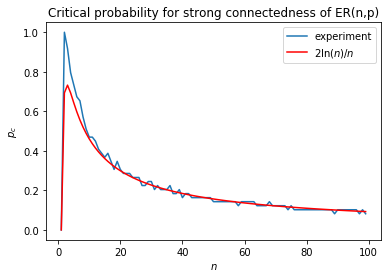

In [77]:
#---------------------------------Confirming classic ER results--------------------------------------------------------
#!!!!!!!!!!!!!!!!!!!!!!!!! NOTE: GENERATING GRAPH TAKES ABOUT A MINUTE !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1



#Interestingly, we seem to confirm the classic results about Erdos-Renyi. 
#ER(n,p) appears to be almost surely SCC connected for p=theta(ln(n)/n)
#Let's try to demonstrate this more clearly; we plot as a function of n the smallest p for which ER(p,n) is almost surely connected

n_max=100
nb_p=50
nb_runs=100 #number of runs to collect statistics on ER(n,p) graphs
p_critical=[]
probs=np.linspace(0,1,nb_p)
threshold_prob=0.95

start=time()

print("Generating ER(n,p) " +str(nb_runs)+" times for each n<="+str(n_max)+", for "+str(nb_p)+" values of p ...\n")
for n in range(1,n_max):
    print("n="+str(n))
    for p in probs:
        count_unique_scc=0

        for run in range(nb_runs):
            g=erdos_renyi(n,p)
            g.findSCCs_korasaju()

            scc_size=[0 for j in range(g.c)]   
            for j in range(len(g.label)): 
                scc_size[g.label[j]]+=1

            # Traverse through array elements  
            # and count frequencies 
            max_scc_size=0

            for i in range(g.c): 
                if scc_size[i]>max_scc_size: max_scc_size=scc_size[i]    

            if max_scc_size==n: count_unique_scc+=1


        prob_unique_scc=count_unique_scc/nb_runs
        if prob_unique_scc>threshold_prob:
            p_critical+=[p]
            break
    
stop=time()
print('runtime ='+str(round((stop-start)))+" s")

#plot prob[whole graph is scc] vs p
plt.figure()
plt.xlabel(r"$n$")
plt.ylabel(r"$p_c$")
plt.title("Critical probability for strong connectedness of ER(n,p)")


experiment,=plt.plot(range(1,n_max),p_critical,label="experiment")
prediction,=plt.plot(range(1,n_max),[2*math.log(n)/n for n in range(1,n_max)],"r",label=r'$2\ln(n)/n$')

plt.legend(handles=[experiment, prediction])




#                                           Part III: DBSCAN

###                                                        POINT CLASS

In [19]:
class point:
    d=2
   
    def __init__(self): 
        self.coords = [0 for i in range(self.d)]


    def dist(self,q):
        squared = 0;
        for i in range(self.d):
            squared += (self.coords[i] - q.coords[i])*(self.coords[i] - q.coords[i]);
        return math.sqrt(squared);
    
    def taxicab_dist(self,q):
        dist= 0;
        for i in range(self.d):
            dist += math.abs(self.coords[i] - q.coords[i])
        return dist
    
def euclidean_dist(points,i,j):
        return points[i].dist(points[j])

def taxicab_dist(points,i,j):
        return points[i].dist(points[j])
    
def haversine_dist(points,i,j):#great-circle distance between two points, used for studying US flight network
   
    lat1=points[i].coords[0]
    lon1=points[i].coords[1]
    
    lat2=points[j].coords[0]
    lon2=points[j].coords[1]
    
    # degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth (km).
    
    return c * r


###                                                 DBSCAN 

In [20]:
#------------------------------DBSCAN---------------------------------------------------------------------------
'''
INPUT:

n = nb points
distFunc: distance function from [0,n-1]x[0,n-1] to R
eps=search radius
minPts=min number of neighbors in search radius to define a core points
#args=False to not print out results

OUTPUT: nb clusters, cluster labels

'''
def dbscan(points, distFunc, eps, minPts, *args): 
    n=len(points)
    C = -1# cluster label                                                 
    label=[-2 for i in range(n)]
    
    for p in range(n):
        if (label[p]!=-2): 
            continue #if point p is already processed  
            
        N_p = neighbors(points,distFunc, p, eps);#compute epsilon-neighborhood
        if (len(N_p) < minPts):#density check                            
            label[p] = -1# Label as Noise (-1)
            continue
        
        C+=1 #move on to next cluster   
                                           
        label[p] = C #label initial point
        S=N_p#seed neighbors to explore, managed in queue
        
        while (S!=[]): #do BFS on seeds
            q=S.pop()
            if (label[q]==-1): label[q]= C;#noise becomes border point
            if (label[q] !=-2):  continue     
            label[q] = C
            N_q= neighbors(points, distFunc, q, eps); 
            if (len(N_q)>=minPts):                     
                for i in range(len(N_q)): S.append(N_q[i])
    if len(args)==0:
        print("Number of clusters: " +str(C+1))
        print("Number of outliers: ",label.count(-1))
    return C+1,label


#calculate epsilon neighbors
def neighbors(points,distFunc, q, eps):
    n=len(points)
    N=[]
    for w in range(n): #check all points in 'points'
        if (distFunc(points,q,w) <=eps):                 
            N.append(w)  
    return N



###                                                 TESTING DBSCAN ON SYNTHETIC DATA

minPts=10, eps=2
Number of clusters: 3
Number of outliers:  0


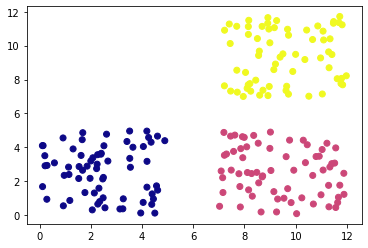

minPts=13, eps=1
Number of clusters: 4
Number of outliers:  24


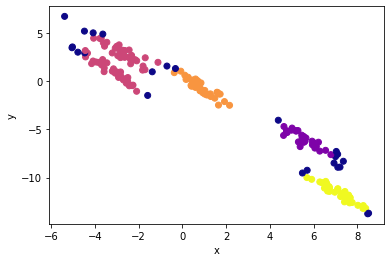

minPts=8, eps=0.3
Number of clusters: 2
Number of outliers:  0


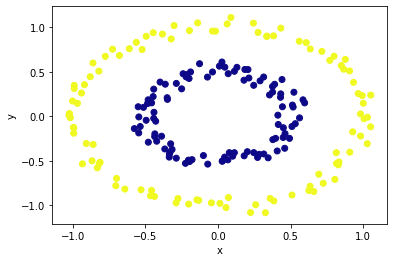

minPts=10, eps=0.22
Number of clusters: 2
Number of outliers:  0


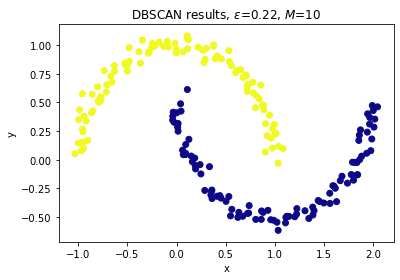

minPts=10, eps=0.1
Number of clusters: 5
Number of outliers:  121


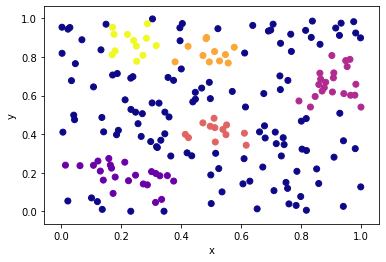

In [22]:
#-----------------------TESTING DBSCAN ON SYNTHETIC DATA------------------------------------------------------------

def generate_uniform_square(n, L):
    cloud= np.empty(n, dtype=point)#n points in LxL square
    for i in range(n):
        cloud[i]=point()
        cloud[i].coords[0]=random.uniform(0,1)*L
        cloud[i].coords[1]=random.uniform(0,1)*L
    
    return cloud

def generate_blobs(n,centers, radius):#not really good blobs
    cloud= np.empty(n, dtype=point)#n points in LxL square 
    for i in range(n):
        c=len(centers)
        cloud[i]=point()
        cloud[i].coords[0]=centers[i%c][0]+random.uniform(0,1)*radius
        cloud[i].coords[1]=centers[i%c][1]+random.uniform(0,1)*radius

    return cloud

#--------------------------------#Data Set 1:-------------------------------
n=200
L=20
eps=2
minPts=10

print("minPts="+str(minPts)+", eps="+str(eps))

#points=generate_uniform_square(n,L)
centers=[[0,0],[7,0],[7,7]]
radius=5

points=generate_blobs(n,centers,radius)

C,labels=dbscan(points, euclidean_dist, eps, minPts)

plt.figure(2)

#colors = [{ni: indi for indi, ni in enumerate(set(labels))}[ni] for ni in labels]

x=[points[i].coords[0] for i in range(n)]
y=[points[i].coords[1] for i in range(n)]

plt.scatter(x, y, c=labels, cmap="plasma")

plt.show()
#----------------------DATA SET 2: streaks--------------------------------------------------------------
# generate some random cluster data

nb_centers=5
eps=1
minPts=13

print("minPts="+str(minPts)+", eps="+str(eps))
X, y = make_blobs(random_state=170, n_samples=n, centers = nb_centers)
rng = np.random.RandomState(74)
transformation = rng.normal(size=(2, 2))# transform the data to be stretched
X = np.dot(X, transformation)

for i in range(n):
    points[i].coords[0]=X[:, 0][i]
    points[i].coords[1]=X[:, 1][i]


C,labels=dbscan(points, euclidean_dist, eps, minPts)

# plot
plt.figure(3)
plt.scatter(X[:, 0], X[:, 1],c=labels, cmap="plasma")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


#-------------------DATA SET 3: rings-----------------------------------------------------------------------

eps=0.3
minPts=8

print("minPts="+str(minPts)+", eps="+str(eps))
X, y = make_circles(n_samples=n, factor=.5, noise=.05)

for i in range(n):
    points[i].coords[0]=X[:, 0][i]
    points[i].coords[1]=X[:, 1][i]

C,labels=dbscan(points, euclidean_dist, eps, minPts)

# plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1],c=labels, cmap="plasma")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
#-------------------DATA SET 4: half-moons-----------------------------------------------------------------------
eps=0.22
minPts=10

print("minPts="+str(minPts)+", eps="+str(eps))

X, y = make_moons(n_samples=n, noise=.05)

for i in range(n):
    points[i].coords[0]=X[:, 0][i]
    points[i].coords[1]=X[:, 1][i]

C,labels=dbscan(points, euclidean_dist, eps, minPts)

# plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1],c=labels, cmap="plasma")
plt.xlabel("x")
plt.ylabel("y")
plt.title("DBSCAN results, $\epsilon$="+str(eps)+", $M$="+str(minPts))
plt.show()

#-------------------DATA SET 5: no structure-----------------------------------------------------------------------
eps=0.1
minPts=10
print("minPts="+str(minPts)+", eps="+str(eps))
X,y = np.random.rand(n, 2), None
for i in range(n):
    points[i].coords[0]=X[:, 0][i]
    points[i].coords[1]=X[:, 1][i]
C,labels=dbscan(points, euclidean_dist, eps, minPts)

# plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1],c=labels, cmap="plasma")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


###                                                 DBSCAN HEURISTICS AND PERFORMANCE METHODS

Computing silhouette plot for half-moons (40 eps values in [0,1])...



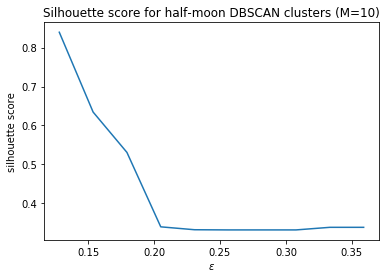

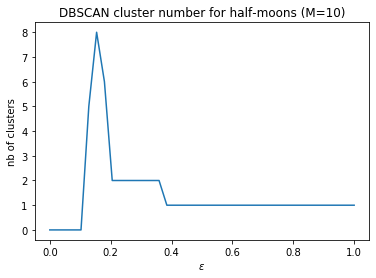

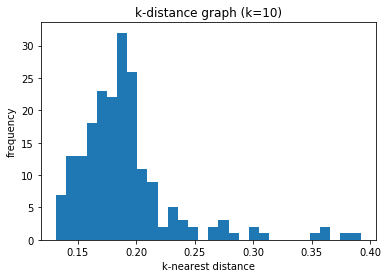

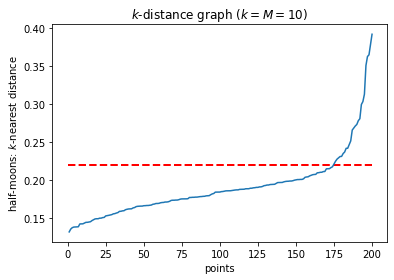

In [24]:
#--------------------DBSCAN heuristics/performance metrics----------------
'''
NOTE: when calculating silhouette score, we must only consider the DBSCAN clusters and not outliers 
thus, we must not calcuate s(i) for i an outlier, and when calculating a(i) and b(i) we should only take
into account distances to points which are not outliers

NOTE: outputs None if nb_c==0 or nb_c==nb_points (silhouette coefficient undefined in this case)


NOTE: GENERATING SILHOUTTE PLOT FOR HALF-MOONS TAKES 15 seconds
'''

#---------------------------------------SILHOUTTE SCORE-----------------------------------------------------
def silhouette_score(points,distFunc,label,nb_c):
    
    if nb_c<=1 or nb_c==len(points): return 
    
    n=len(points)
    
    silh=0 #output=average silhouette score 
    n_effective=0

    for i in range(n):#for each point p in P
        if label[i]==-1: continue #if outlier, ignore
       
        n_effective+=1
        b=sys.maxsize
        #calculate average distance to cluster with label c
        for c in range(nb_c):
            
            average_dist=0#average distance of p to points in cluster c
            cluster_size=0
            for j in range(n):#calculate distance to points[j] in cluster c 
                if (label[j]==c):
                    average_dist+=distFunc(points,i,j) 
                    cluster_size+=1
            
            average_dist=average_dist/cluster_size
            if (c==label[i]): a=average_dist
            elif (average_dist<b): b=average_dist
                  
        silh+=(b-a)/max(a,b)
      
    
    silh=silh/n_effective#compute average of silhouettes over points in DBSCAN clusters
    return silh

#---------------------------------------KNN PLOT-----------------------------------------------------
def kn_distances(points,distFunc,k):

    kn_distance = []
    for i in range(len(points)):
        distances = []
        for j in range(len(points)):
            distances.append(distFunc(points,i,j))
        distances.sort()
        kn_distance.append(distances[k])

    return kn_distance


#---------------------------Example of silhouette plot----------------------------------------------------

X, y = make_moons(n_samples=n, noise=.05)   
for i in range(n):
    points[i].coords[0]=X[:, 0][i]
    points[i].coords[1]=X[:, 1][i]

#for M_points fixed, plot silhouette_scores to find optimal epsilon

s_scores=[]
nb_clusters=[]
minPts=10;
eps_max=1;
num=40;

print("Computing silhouette plot for half-moons ("+str(num)+" eps values in [0,1])...\n")

for eps in np.linspace(0,eps_max,num):
    C,labels=dbscan(points, euclidean_dist, eps,minPts,False)

    s_score=silhouette_score(points,euclidean_dist,labels,C)
    s_scores+=[s_score]
    nb_clusters+=[C]

# plot
plt.figure(4)
plt.plot(np.linspace(0,eps_max,num), s_scores)
plt.xlabel("$\epsilon$")
plt.ylabel("silhouette score")
plt.title("Silhouette score for half-moon DBSCAN clusters (M="+str(minPts)+")")
plt.show()

# plot
plt.figure(4)
plt.plot(np.linspace(0,eps_max,num), nb_clusters)
plt.xlabel("$\epsilon$")
plt.ylabel("nb of clusters")
plt.title("DBSCAN cluster number for half-moons (M="+str(minPts)+")")
plt.show()

kn_dist = kn_distances(points,euclidean_dist,minPts)

# plot
plt.figure(5)
plt.hist(kn_dist,bins=30)
plt.ylabel('frequency');
plt.xlabel('k-nearest distance');
plt.title("k-distance graph (k="+str(minPts)+")")

plt.figure(6)
indices=[i for i in range(1,len(points)+1)]
plt.plot(indices,np.sort(kn_dist))
plt.xlabel('points');
plt.ylabel('half-moons: $k$-nearest distance');
plt.title("$k$-distance graph $(k=M=$"+str(minPts)+")")
plt.hlines(y=0.22, xmin=0, xmax=len(indices), colors='r', linestyles='--', lw=2)


###                                                 REAL DATASET #1: IRIS

loading data...
Running DBSCAN(eps=0.3, minPts=4)...
runtime =16 ms

N=150
Number of clusters: 3
Number of outliers:  9


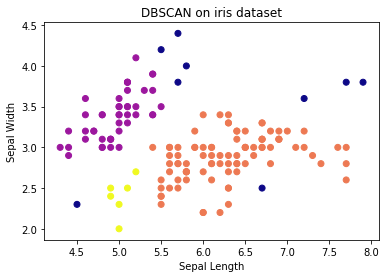

Text(0.5, 1.0, 'k-distance graph (k=minPts)')

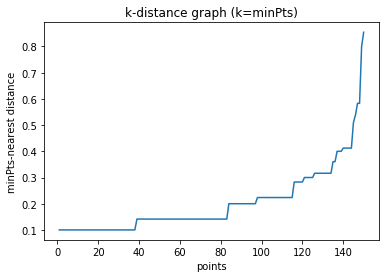

In [25]:
#-----------------------TESTING DBSCAN ON REAL DATA------------------------------------------------------------

#---------------------------------------------DATASET #1: IRIS2-----------------------------------------------------
#we use points (x,y) with x,y the first two dimmensions in iris2 dataset

del points
points=[]
x_coords=[]
y_coords=[]

#-----------------load data from file
file_name='iris'
file_type='.txt'

print("loading data...")

f=open(file_name+file_type,'r') 
lines = f.readlines()

for line in lines:
    parsed = line.split(",")
    p=point()

    p.coords[0]=float(parsed[0])
    p.coords[1]=float(parsed[1])
    points+=[p]

    x_coords+=[float(parsed[0])]
    y_coords+=[float(parsed[1])]
    
f.close() 

#---------------Run DBSCAN

minPts=4
eps=0.3
print("Running DBSCAN(eps=" + str(eps)+", minPts="+str(minPts)+")...")
print('runtime ='+str(round((stop-start)*1000.0))+" ms\n")

print("N="+str(len(points)))

start=time()
c,labels=dbscan(points, euclidean_dist, eps, minPts)
stop=time()

# plot

plt.figure()
plt.scatter(x_coords, y_coords,c=labels, cmap="plasma")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("DBSCAN on iris dataset")
plt.show()

#kn-distance
kn_dist = kn_distances(points,euclidean_dist,minPts)

plt.figure()
indices=[i for i in range(1,len(points)+1)]
plt.plot(indices,np.sort(kn_dist))
plt.xlabel('points');
plt.ylabel('minPts-nearest distance');
plt.title("k-distance graph (k=minPts)")
#plt.hlines(y=1.8, xmin=0, xmax=len(indices), colors='r', linestyles='--', lw=2)


###                                                 REAL DATA SET #2: COVID-19 NB CASES/NB DEATHS

loading data...
Running DBSCAN(eps=20000, minPts=3)...
runtime =22 ms

N=173
Number of clusters: 3
Number of outliers:  4


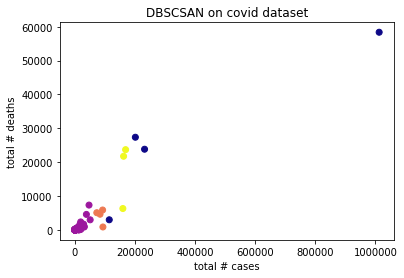

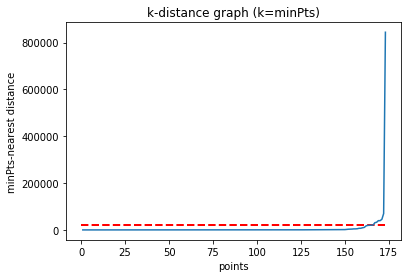

In [26]:
#---------------------------------------------DATASET #2: Covid-19-----------------------------------------------------
#we run DBSCAN in 2-D using information about Covid-19 in each country; dim0=total # cases dim1=total # deaths
#goal: determine clusters of countries 
#distance=euclidean distance

del points
points=[]
x_coords=[]
y_coords=[]
country_names=[]

#-----------------load data from file
file_name='covid data'
file_type='.txt'
skip=1;

print("loading data...")

f=open(file_name+file_type,'r') 
lines = f.readlines()[skip:] 

for line in lines:
    parsed = line.split()  
    country_names+=[parsed[1]]
   
    p=point()
    p.coords[0]=float(parsed[2])
    p.coords[1]=float(parsed[3])
    points+=[p]

    x_coords+=[float(parsed[2])]
    y_coords+=[float(parsed[3])]
    
f.close() 

#---------------Run DBSCAN

minPts=3
eps=20000
print("Running DBSCAN(eps=" + str(eps)+", minPts="+str(minPts)+")...")
print('runtime ='+str(round((stop-start)*1000.0))+" ms\n")

print("N="+str(len(points)))

start=time()
c,labels=dbscan(points, euclidean_dist, eps, minPts)
stop=time()

# plot

plt.figure()
plt.scatter(x_coords, y_coords,c=labels, cmap="plasma")
plt.xlabel("total # cases")
plt.ylabel("total # deaths")
plt.title("DBSCSAN on covid dataset")
plt.show()

#kn-distance
kn_dist = kn_distances(points,euclidean_dist,minPts)

plt.figure()
indices=[i for i in range(1,len(points)+1)]
plt.plot(indices,np.sort(kn_dist))
plt.xlabel('points');
plt.ylabel('minPts-nearest distance');
plt.title("k-distance graph (k=minPts)")
plt.hlines(y=eps, xmin=0, xmax=len(indices), colors='r', linestyles='--', lw=2)











#                    Part IV: COMPARING SCC-FINDERS AND DBSCAN

###                                             SYNTHETIC DATASET: PRETTY UNINTERESTING (CAN IGNORE)

Number of clusters: 1
Number of outliers:  100


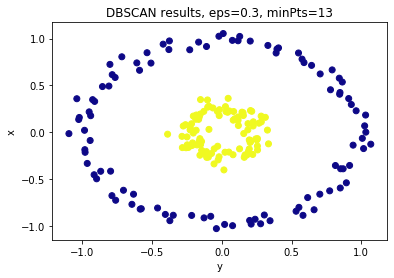

normalisation=8.182999536112433e-05
G=(V,E), V=200, E=554 edges


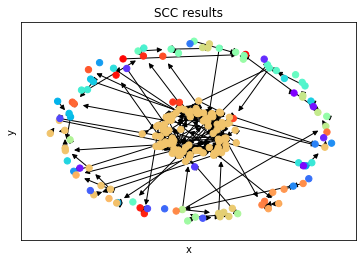


# SCC (korasaju): 90


In [27]:
#---------------------------------------Comparing DBSCAN and SCC algorithms------------------------------------------------------

#---------------------------DATA SET 1 (SYNTHETIC)---------------------------------------------
#we start with a set of blobs in the plane; we can run DBSCAN on this with euclidean distance
#we createa graph with points as nodes, and connected points with edges
#with probability proportional to 1/distance^2. we find the SCC of the graph and compare

n=200
eps=0.3
minPts=13

X, y = make_circles(n_samples=n, factor=0.25, noise=.05)

del points
points=[]
pos={}

for i in range(n):
    p=point()
    p.coords[0]=X[:, 0][i]
    p.coords[1]=X[:, 1][i]
    pos[i]=(X[:, 0][i],X[:, 1][i])
    points+=[p]

C,labels=dbscan(points, euclidean_dist, eps, minPts)

# plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1],c=labels, cmap="plasma")
plt.xlabel("y")
plt.ylabel("x")
plt.title("DBSCAN results, eps="+str(eps)+", minPts="+str(minPts))
plt.show()

del g
g=Graph(n); 

normalisation=sys.maxsize#normalisation=min distance squared
for i in range(n):
    for j in range(n):
        if i==j: continue
        x=points[i].dist(points[j])**2
        if x<normalisation: normalisation=x

print("normalisation="+str(normalisation))

normalisation=0.05**2

for i in range(n):
    for j in range(i+1,n):
        #if i==j: continue 
        r=random.uniform(0,1)
        p=normalisation/(points[i].dist(points[j])**2)
        if (r<=p):
            f=random.uniform(0,1)
            if (f<=0.5):g.addEdge(i,j)
            else: g.addEdge(j,i)

print ("G=(V,E), V=" + str(g.V)+ ", E=" +str(g.E)+ " edges")
g.findSCCs_korasaju() 

node_size=40
x_label="x"
y_label="y"
title="SCC results"
g.display(False,pos, node_size, x_label,y_label, title)


print ("\n# SCC (korasaju): "+str(g.c))

###                                            US FLIGHT NETWORK DATASET

In [28]:
#-----------------------------------COMPARING SCC ALGORITHMS WITH DBSCAN ON US AIRPORT DATA-----------------------
'''
Input data: 

-Information about airports across the globe (airport name, city, country, and latitude/longitude)
-List of COMMMERCIAL flights between airports (airline, source airport, destination airport, etc)
https://openflights.org/data.html#airport


-Goal: determine clustering of airports in mainland USA via

1. DBSCAN, using great-circle distance between airports
2. SCC-finding algorithm, where mainland US aiports form nodes of graph, and directed edges indicate flights

NOTE: the airport data is likely close to complete however the route data is probably very incomplete for small airports
'''
#--------------------------------------LOAD AND FORMAT DATA-----------------------------------------------------

print("Loading airport and route data...")

#world airport info
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("airports.dat.txt", names = airport_col, index_col = 0)

#route info
route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("routes.dat.txt", names = route_cols)
#reformat data
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 

#extract all US airports in including alaska and overseas
airport_us = airport_df[(airport_df.Country == "United States")][['Name','Lat', 'Long', 'IATA', 'ICAO']]
# to study world airports comment above line and replace by: airport_us = airport_df['Name','Lat', 'Long', 'IATA', 'ICAO']

#extract only mainland USA airports
airport_us = airport_us[(airport_us.Lat > 25) & (airport_us.Lat < 50) & (airport_us.Long > -130) & (airport_us.Long < -60)]
#to study world airports simply comment  above line

us_airport_ix = airport_us.index.values

routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes inter-USA
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport ID', 'Dest Airport ID']).size().reset_index(name='counts'))

#------------------------------------DEFINE GRAPHS AND NODE COORDINATES---------------------------------------------------
print("Building graph...")

points=[]
pos={}
consecutive_ind=dict() #we map US Airport identifiers to consecutive indices 0,1, to be able to run Tarjan, etc...

i=0
for index,row in airport_us.iterrows():  
    p=point()
    p.coords[0]=float(row[1]) # longitude
    p.coords[1]=float(row[2]) #latitude
    pos[i]=(p.coords[1],p.coords[0])
    points+=[p]
    consecutive_ind[index]=i
    i+=1
    
def get_airport_index_of(i): #reverse dictionary: find key from value
    for item  in consecutive_ind.items():
        if item[1] == i:
            return item[0]

n=len(points)# airports

g=Graph(n)

for index, row in routes_us.iterrows():
   i=consecutive_ind[row[0]]
   j=consecutive_ind[row[1]]
   g.addEdge(i,j)

print("Done!")



Loading airport and route data...
Building graph...
Done!


Nb of airports in mainland US: 1298
Nb of routes in network: 4948


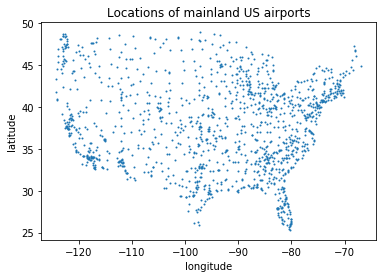

Rendering network...


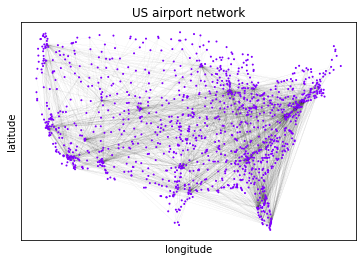

Visualization complete!


In [29]:
#-----------------------------DISPLAY DATA---------------------------------------

print("Nb of airports in mainland US: "+str(g.V))
print("Nb of routes in network: "+str(g.E))

plt.figure()
plt.scatter(x=airport_us['Long'], y=airport_us['Lat'],s=1)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Locations of mainland US airports")
plt.show()

print("Rendering network...")

node_size=1
edge_width=0.01
arrows=False

x_label="longitude"
y_label="latitude"
title="US airport network"
g.display(False,pos, node_size, x_label,y_label, title,edge_width,arrows)
print("Visualization complete!")


Generating knn plots...


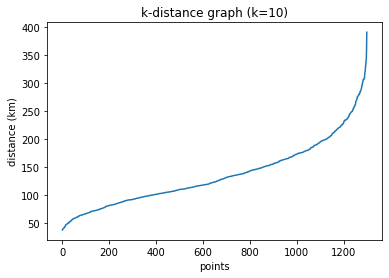

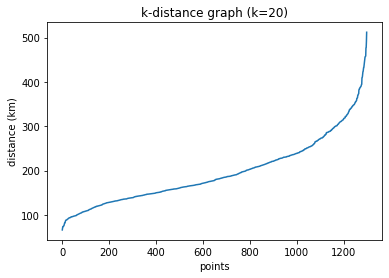

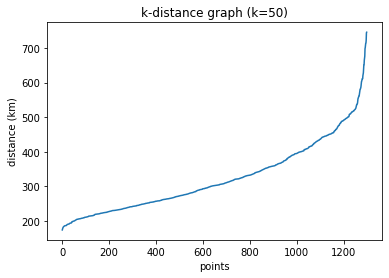

Running DBSCAN(eps=50,minPts=10)...
Number of clusters: 7
Number of outliers:  1202
silhouette score: 0.9027201765343323
runtime =3944 ms


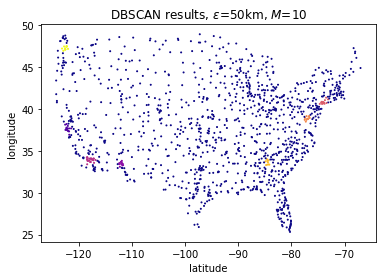

Running DBSCAN(eps=100,minPts=10)...
Number of clusters: 21
Number of outliers:  560
silhouette score: 0.4725148281152376
runtime =3730 ms


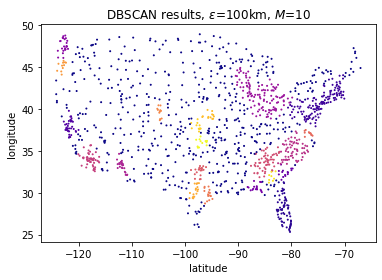

Running DBSCAN(eps=150,minPts=10)...
Number of clusters: 10
Number of outliers:  197
silhouette score: 0.11485817149797767
runtime =3595 ms


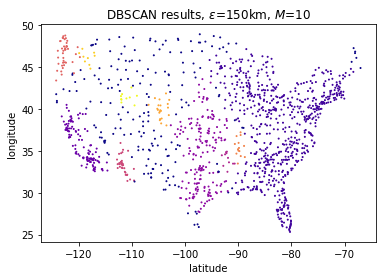

Running DBSCAN(eps=300,minPts=20)...
Number of clusters: 2
Number of outliers:  18
silhouette score: 0.32958514659289473
runtime =3825 ms


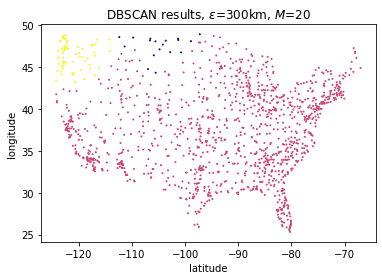

Running DBSCAN(eps=300,minPts=50)...
Number of clusters: 4
Number of outliers:  238
silhouette score: 0.4559873399877456
runtime =4322 ms


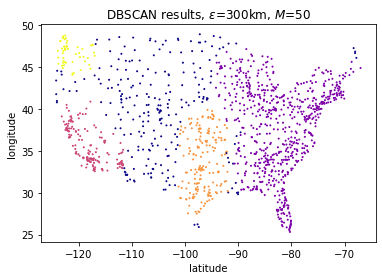

Running DBSCAN(eps=550,minPts=50)...
Number of clusters: 1
Number of outliers:  0
silhouette score: None
runtime =4420 ms


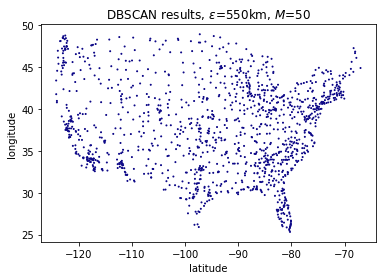

Running DBSCAN(eps=300,minPts=100)...
Number of clusters: 1
Number of outliers:  1198
silhouette score: None
runtime =4290 ms


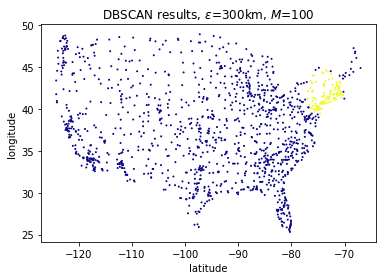

done!


In [30]:
#-------------------------------------Part 1: RUN DBSCAN---------------------------------------------------------
print("Generating knn plots...")

#knn graph
for minPts in [10,20,50]:
    kn_dist = kn_distances(points,haversine_dist,minPts)

    plt.figure()
    indices=[i for i in range(1,len(points)+1)]
    plt.plot(indices,np.sort(kn_dist))
    plt.xlabel('points');
    plt.ylabel('distance (km)');
    plt.title("k-distance graph (k="+str(minPts)+")")
    plt.show()

#------------------------------------------------------------------------------
#RUN DBSCAN for different hyperparameters

trial_minPts=[10,10,10,20,50,50,100]
trial_eps=[50,100,150,300,300,550,300]


for i in range(len(trial_minPts)):
    
    minPts=trial_minPts[i]
    eps=trial_eps[i]
    
    print("Running DBSCAN(eps="+str(eps)+",minPts="+str(minPts)+")...")
    start=time()
    C,labels=dbscan(points, haversine_dist, eps, minPts)
    stop=time()
    print("silhouette score: "+str(silhouette_score(points,haversine_dist,labels,C)))
    print('runtime ='+str(round((stop-start)*1000.0))+" ms")

    # plot
    plt.figure()
    plt.scatter(x=airport_us['Long'], y=airport_us['Lat'],c=labels, cmap="plasma",s=1)
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.title("DBSCAN results, $\epsilon$="+str(eps)+"km, $M$="+str(minPts))
    plt.show()

#--------------------------------------------------------------------------------------
print("done!")


# SCC (korasaju): 898


clustersize | frequency
1  | 896
4  | 1
398  | 1

Airports in the SCC of size 4: 

Boeing Field King County International Airport (Seattle)
William R Fairchild International Airport (Port Angeles)
Friday Harbor Airport (Friday Harbor)
Orcas Island Airport (Eastsound)

Rendering network...

Singleton clusters displayed in red, main cluster in purple
NOTE: Singleton clusters in fact correspond to airports with no in/out routes in database


<Figure size 432x288 with 0 Axes>

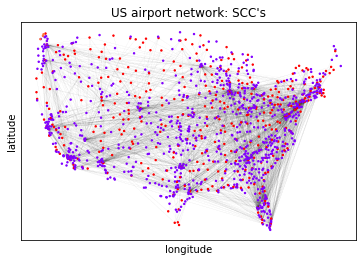

done!


In [31]:
#------------------------------PART 2: FIND SCC's with Korasaju------------------------------------------------
plt.figure()

g.findSCCs_korasaju() 

print ("\n# SCC (korasaju): "+str(g.c)+"\n")

#calculte frequency distribution
g.freq_plot(False) 

#mark singleton SCC's as same color for visibility, and find 

print("\nAirports in the SCC of size 4: \n")

size=[0 for j in range(g.c)]
for j in range(len(g.label)): size[g.label[j]]+=1
for i in range(g.V):
    if size[g.label[i]]==1: 
        g.label[i]=-1
    if size[g.label[i]]==4: 
        print(airport_us['Name'][get_airport_index_of(i)]+" ("+airport_df['City'][get_airport_index_of(i)]+")")
        


print("\nRendering network...")
print("\nSingleton clusters displayed in red, main cluster in purple")
print("NOTE: Singleton clusters in fact correspond to airports with no in/out routes in database")
node_size=2
edge_width=0.01
arrows=False

x_label="longitude"
y_label="latitude"
title="US airport network: SCC's"


g.display(False,pos, node_size, x_label,y_label, title,edge_width,arrows)

print("done!")
